# Task 3: Claim vs Reference vs Context Classification

This notebook implements a machine learning pipeline for classifying scientific tweets into three categories:
- Claim (0)
- Context (1)
- Reference (2)

## Setup

Import required libraries and configure warnings

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, make_scorer
)
import optuna
import emoji
import re
import scipy.sparse
import spacy
from langdetect import detect

## Data Loading and Preprocessing

Load the dataset and prepare it for multiclass classification

Loading data...

Class distribution:
label
2    203
0    124
1     48
Name: count, dtype: int64


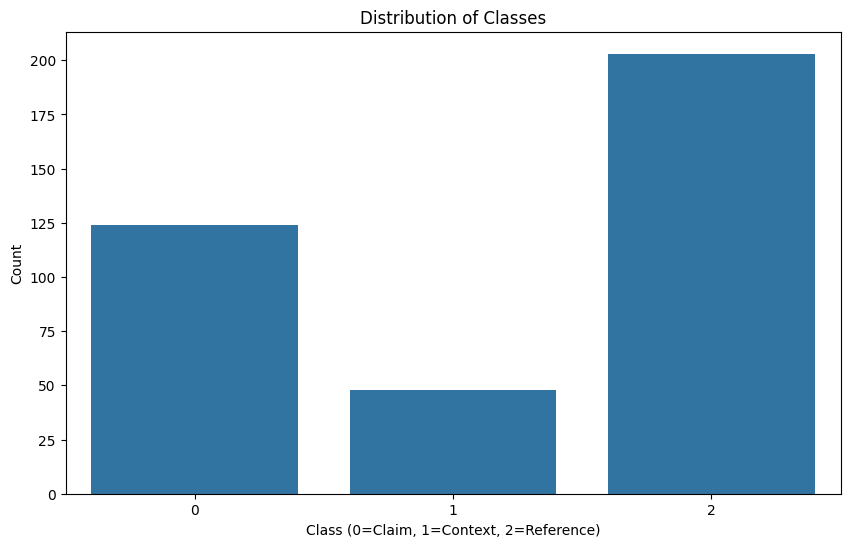

In [9]:
# Load data
print("Loading data...")
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Filter scientific tweets only
df_sci = df[df['science_related'] == 1].copy()

# Create multiclass labels
df_sci['label'] = None
df_sci.loc[df_sci['scientific_claim'] == 1, 'label'] = 0  # CLAIM
df_sci.loc[df_sci['scientific_context'] == 1, 'label'] = 1  # CONTEXT
df_sci.loc[df_sci['scientific_reference'] == 1, 'label'] = 2  # REF

# Remove rows without a clear single label and convert to int
df_clean = df_sci.dropna(subset=['label']).copy()
df_clean['label'] = df_clean['label'].astype('int')

# Display class distribution
print("\nClass distribution:")
print(df_clean['label'].value_counts())

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='label')
plt.title('Distribution of Classes')
plt.xlabel('Class (0=Claim, 1=Context, 2=Reference)')
plt.ylabel('Count')
plt.show()

## ModelPipeline Class Definition

Pipeline adapted for multiclass classification

In [13]:
class ModelPipeline:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Naïve Bayes": MultinomialNB(),
            "Random Forest": RandomForestClassifier(n_jobs=-1),
            "SVM": SVC(kernel='linear'),
            "KNN": KNeighborsClassifier(n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score, average='weighted'),
            "Recall": make_scorer(recall_score, average='weighted'),
            "F1 Score": make_scorer(f1_score, average='weighted')
        }
        self.results = {}

    def preprocess_data(self, df, with_preprocessing=False):
        """Preprocess data based on the phase (with or without preprocessing)"""
        # Convert emojis
        df['text'] = df['text'].apply(lambda x: emoji.demojize(x))
        
        # Add binary features
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
        
        if with_preprocessing:
            try:
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            except OSError:
                print("Installing spaCy models...")
                import os
                os.system("python -m spacy download fr_core_news_sm")
                os.system("python -m spacy download en_core_web_sm")
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            
            def clean_and_lemmatize_multilang(text):
                text = text.lower()
                text = re.sub(r"http\S+", "URL", text)
                text = re.sub(r"@\w+", "MENTION", text)
                text = re.sub(r"#(\w+)", r"\1", text)
                text = re.sub(r"[^\w\s:]", "", text)
                try:
                    lang = detect(text)
                except:
                    lang = "en"
                doc = nlp_fr(text) if lang == "fr" else nlp_en(text)
                return " ".join([token.lemma_ for token in doc if not token.is_stop])
            
            df['text_clean'] = df['text'].apply(clean_and_lemmatize_multilang)
            text_column = 'text_clean'
        else:
            text_column = 'text'

        return df, text_column

    def prepare_features(self, df, text_column, stopwords=None, max_features=10000):
        """Prepare feature matrix from preprocessed data"""
        vectorizer = TfidfVectorizer(
            min_df=5,
            max_df=0.95,
            stop_words=stopwords,
            lowercase=True,
            ngram_range=(1, 2),
            max_features=max_features
        ) if stopwords else TfidfVectorizer(max_features=max_features)
        
        X_text = df[text_column]
        X_tfidf = vectorizer.fit_transform(X_text)
        
        extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)
        
        X_final = scipy.sparse.hstack([X_tfidf, X_extra])
        
        return X_final, vectorizer

    def train_and_evaluate(self, X, y, phase_name):
        """Train and evaluate models using k-fold cross-validation"""
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []
        
        for name, model in self.models.items():
            print(f"\n🔍 Training model: {name}")
            
            fold_metrics = {
                "Accuracy": [],
                "Precision": [],
                "Recall": [],
                "F1": []
            }
            
            # Convert y to numpy array
            y_array = y.values
            
            for fold, (train_idx, test_idx) in enumerate(cv.split(X.toarray() if scipy.sparse.issparse(X) else X, y_array), 1):
                X_train = X[train_idx] if scipy.sparse.issparse(X) else X[train_idx]
                X_test = X[test_idx] if scipy.sparse.issparse(X) else X[test_idx]
                y_train = y_array[train_idx]
                y_test = y_array[test_idx]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                fold_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
                fold_metrics["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
                fold_metrics["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
                fold_metrics["F1"].append(f1_score(y_test, y_pred, average='weighted'))
                
                if fold == cv.n_splits:
                    plt.figure(figsize=(8, 6))
                    cm = confusion_matrix(y_test, y_pred)
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                    plt.title(f'Confusion Matrix - {name} ({phase_name})\nClaim(0) vs Context(1) vs Ref(2)')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.show()
                    
                    print("\nClassification Report:")
                    print(classification_report(y_test, y_pred, 
                                              target_names=['Claim', 'Context', 'Reference']))
            
            metrics = {
                "Model": name,
                "Phase": phase_name
            }
            
            for metric_name, scores in fold_metrics.items():
                metrics[metric_name] = np.mean(scores)
                metrics[f"{metric_name}_Std"] = np.std(scores)
                print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            
            results.append(metrics)
        
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'model_results_task3_{phase_name.lower().replace(" ", "_")}.csv', index=False)
        return results_df

## Initialize Pipeline

In [11]:
# Initialize pipeline
pipeline = ModelPipeline()

## Phase 1: Without Preprocessing

Process and evaluate models using basic preprocessing

=== Phase 1: Without Preprocessing ===

🔍 Training model: Naïve Bayes


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

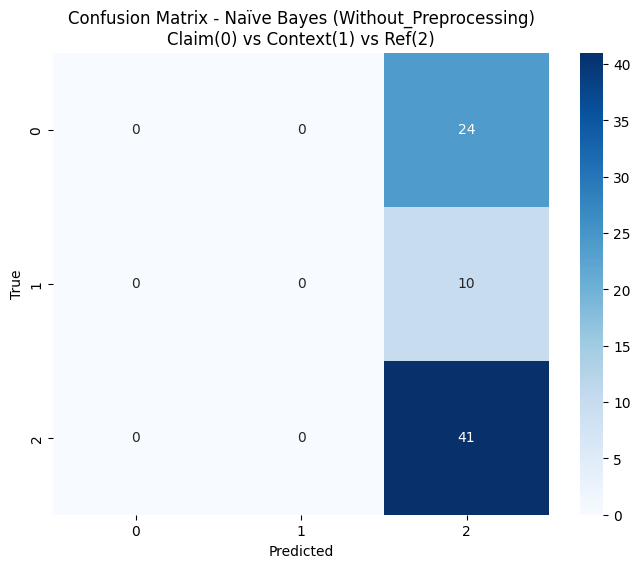


Classification Report:
              precision    recall  f1-score   support

       Claim       0.00      0.00      0.00        24
     Context       0.00      0.00      0.00        10
   Reference       0.55      1.00      0.71        41

    accuracy                           0.55        75
   macro avg       0.18      0.33      0.24        75
weighted avg       0.30      0.55      0.39        75

Accuracy: 0.5547 ± 0.0107
Precision: 0.4970 ± 0.1620
Recall: 0.5547 ± 0.0107
F1: 0.4085 ± 0.0226

🔍 Training model: Random Forest


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

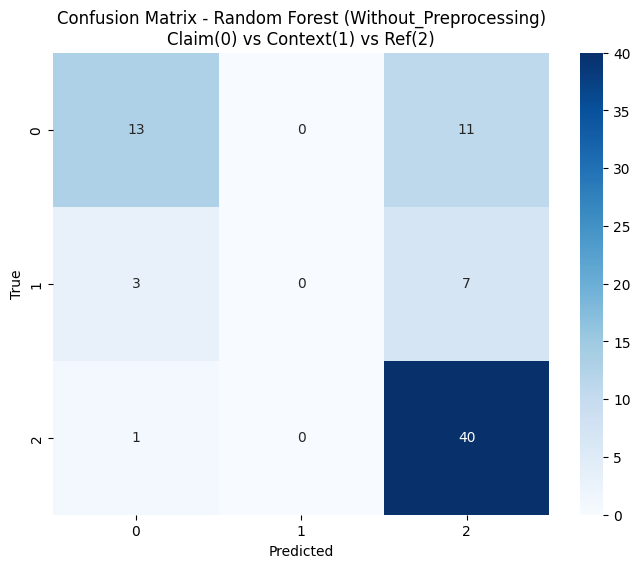

/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi


Classification Report:
              precision    recall  f1-score   support

       Claim       0.76      0.54      0.63        24
     Context       0.00      0.00      0.00        10
   Reference       0.69      0.98      0.81        41

    accuracy                           0.71        75
   macro avg       0.48      0.51      0.48        75
weighted avg       0.62      0.71      0.64        75

Accuracy: 0.6880 ± 0.0136
Precision: 0.6229 ± 0.0118
Recall: 0.6880 ± 0.0136
F1: 0.6242 ± 0.0174

🔍 Training model: SVM


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


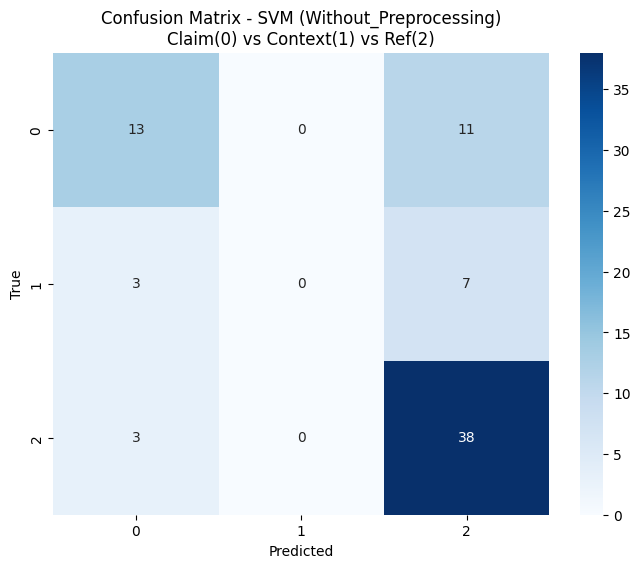


Classification Report:
              precision    recall  f1-score   support

       Claim       0.68      0.54      0.60        24
     Context       0.00      0.00      0.00        10
   Reference       0.68      0.93      0.78        41

    accuracy                           0.68        75
   macro avg       0.45      0.49      0.46        75
weighted avg       0.59      0.68      0.62        75

Accuracy: 0.6773 ± 0.0155
Precision: 0.6120 ± 0.0196
Recall: 0.6773 ± 0.0155
F1: 0.6128 ± 0.0216

🔍 Training model: KNN


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

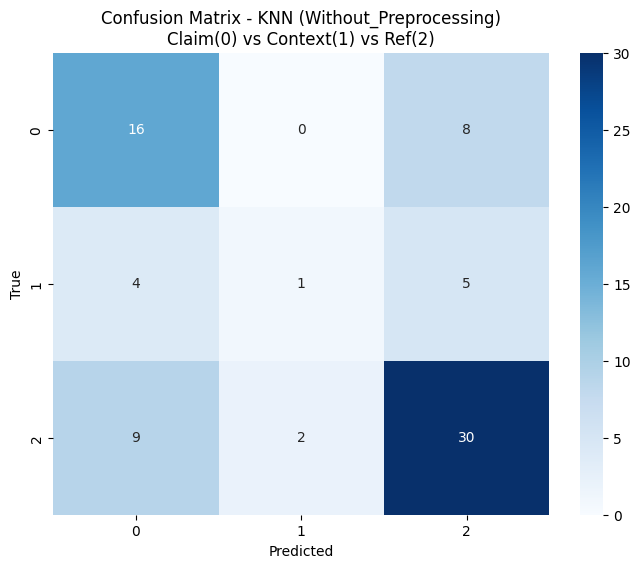


Classification Report:
              precision    recall  f1-score   support

       Claim       0.55      0.67      0.60        24
     Context       0.33      0.10      0.15        10
   Reference       0.70      0.73      0.71        41

    accuracy                           0.63        75
   macro avg       0.53      0.50      0.49        75
weighted avg       0.60      0.63      0.60        75

Accuracy: 0.6293 ± 0.0297
Precision: 0.5924 ± 0.0217
Recall: 0.6293 ± 0.0297
F1: 0.6042 ± 0.0235

🔍 Training model: AdaBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


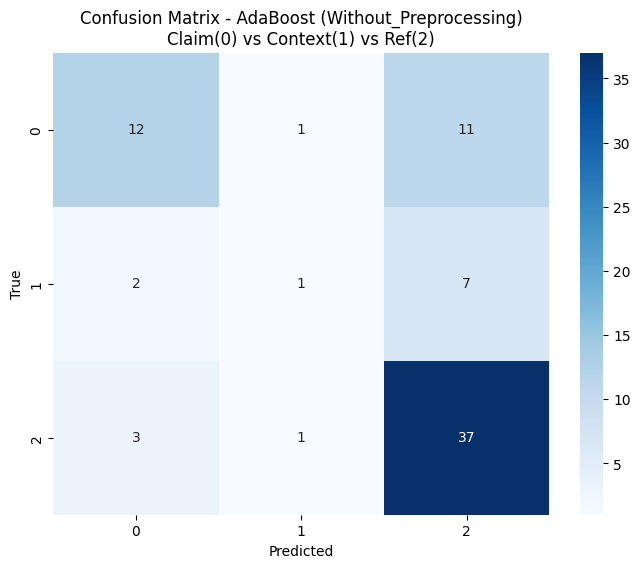


Classification Report:
              precision    recall  f1-score   support

       Claim       0.71      0.50      0.59        24
     Context       0.33      0.10      0.15        10
   Reference       0.67      0.90      0.77        41

    accuracy                           0.67        75
   macro avg       0.57      0.50      0.50        75
weighted avg       0.64      0.67      0.63        75

Accuracy: 0.6853 ± 0.0200
Precision: 0.6601 ± 0.0618
Recall: 0.6853 ± 0.0200
F1: 0.6408 ± 0.0312

🔍 Training model: XGBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:58:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:58:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: 

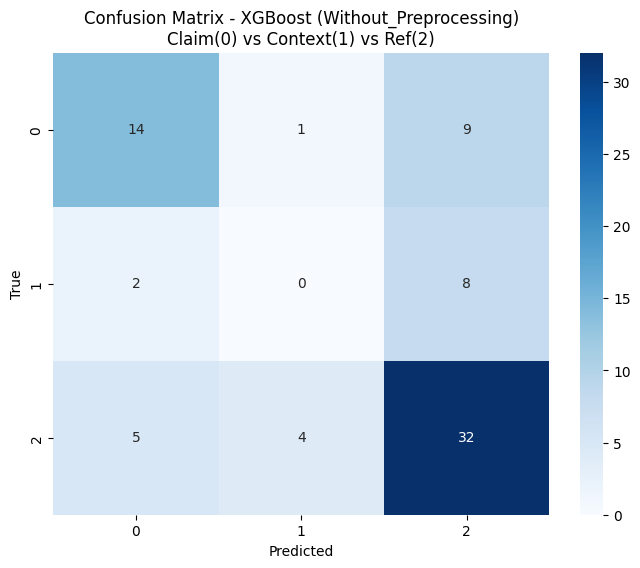


Classification Report:
              precision    recall  f1-score   support

       Claim       0.67      0.58      0.62        24
     Context       0.00      0.00      0.00        10
   Reference       0.65      0.78      0.71        41

    accuracy                           0.61        75
   macro avg       0.44      0.45      0.44        75
weighted avg       0.57      0.61      0.59        75

Accuracy: 0.6480 ± 0.0232
Precision: 0.6119 ± 0.0313
Recall: 0.6480 ± 0.0232
F1: 0.6165 ± 0.0177

🔍 Training model: Neural Network - MLP


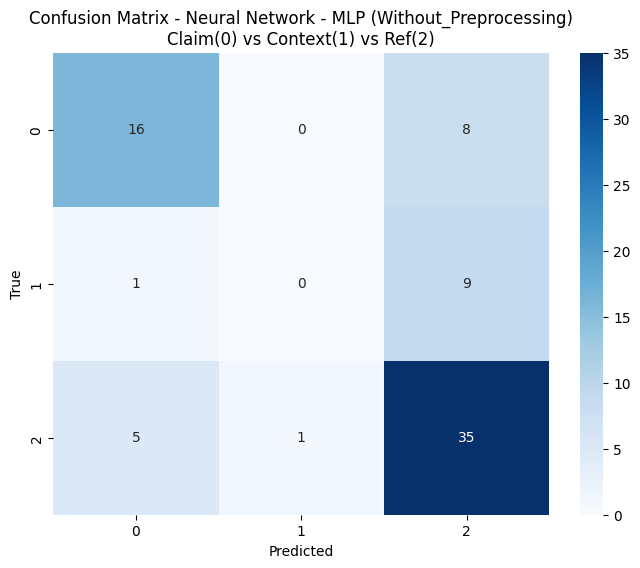


Classification Report:
              precision    recall  f1-score   support

       Claim       0.73      0.67      0.70        24
     Context       0.00      0.00      0.00        10
   Reference       0.67      0.85      0.75        41

    accuracy                           0.68        75
   macro avg       0.47      0.51      0.48        75
weighted avg       0.60      0.68      0.63        75

Accuracy: 0.6640 ± 0.0320
Precision: 0.6285 ± 0.0598
Recall: 0.6640 ± 0.0320
F1: 0.6179 ± 0.0351

Phase 1 Results:


,Model,Phase,Accuracy,Accuracy_Std,Precision,Precision_Std,Recall,Recall_Std,F1,F1_Std
0,Naïve Bayes,Without_Preprocessing,0.554667,0.010667,0.497049,0.161954,0.554667,0.010667,0.408469,0.022588
1,Random Forest,Without_Preprocessing,0.688000,0.013597,0.622914,0.011774,0.688000,0.013597,0.624181,0.017415
2,SVM,Without_Preprocessing,0.677333,0.015549,0.612017,0.019632,0.677333,0.015549,0.612779,0.021621
3,KNN,Without_Preprocessing,0.629333,0.029695,0.592363,0.021672,0.629333,0.029695,0.604217,0.023529
4,AdaBoost,Without_Preprocessing,0.685333,0.019956,0.660127,0.061834,0.685333,0.019956,0.640777,0.031154
5,XGBoost,Without_Preprocessing,0.648000,0.023247,0.611934,0.031337,0.648000,0.023247,0.616496,0.017733
6,Neural Network - MLP,Without_Preprocessing,0.664000,0.032000,0.628465,0.059774,0.664000,0.032000,0.617918,0.035108


In [12]:
print("=== Phase 1: Without Preprocessing ===")
df_phase1, text_column = pipeline.preprocess_data(df_clean.copy(), with_preprocessing=False)
X_phase1, _ = pipeline.prepare_features(df_phase1, text_column)
results_phase1 = pipeline.train_and_evaluate(X_phase1, df_clean['label'], "Without_Preprocessing")

print("\nPhase 1 Results:")
display(results_phase1)

## Phase 2: With Preprocessing

Process and evaluate models using advanced preprocessing techniques

=== Phase 2: With Preprocessing ===
Installing spaCy models...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 12.9 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.6 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')

🔍 Training model: Naïve Bayes


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

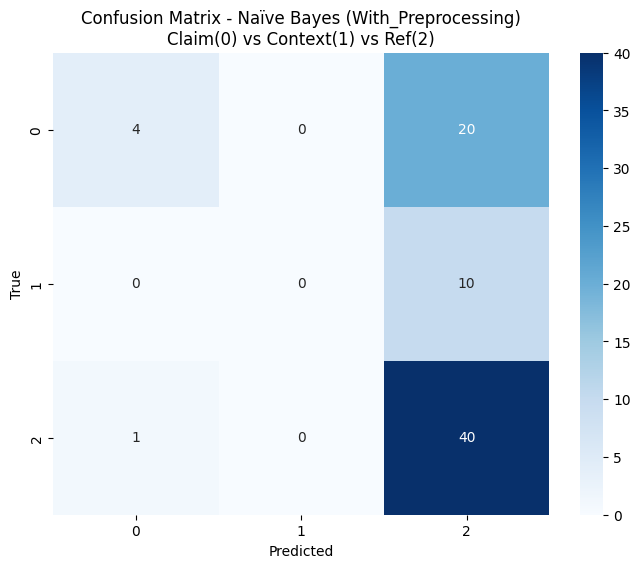


Classification Report:
              precision    recall  f1-score   support

       Claim       0.80      0.17      0.28        24
     Context       0.00      0.00      0.00        10
   Reference       0.57      0.98      0.72        41

    accuracy                           0.59        75
   macro avg       0.46      0.38      0.33        75
weighted avg       0.57      0.59      0.48        75

Accuracy: 0.5733 ± 0.0119
Precision: 0.6209 ± 0.0270
Recall: 0.5733 ± 0.0119
F1: 0.4490 ± 0.0249

🔍 Training model: Random Forest


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

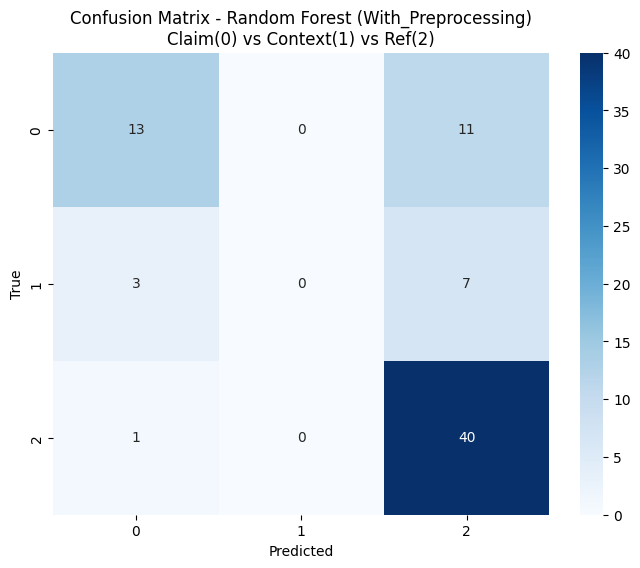

/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi


Classification Report:
              precision    recall  f1-score   support

       Claim       0.76      0.54      0.63        24
     Context       0.00      0.00      0.00        10
   Reference       0.69      0.98      0.81        41

    accuracy                           0.71        75
   macro avg       0.48      0.51      0.48        75
weighted avg       0.62      0.71      0.64        75

Accuracy: 0.6827 ± 0.0177
Precision: 0.6185 ± 0.0141
Recall: 0.6827 ± 0.0177
F1: 0.6206 ± 0.0192

🔍 Training model: SVM


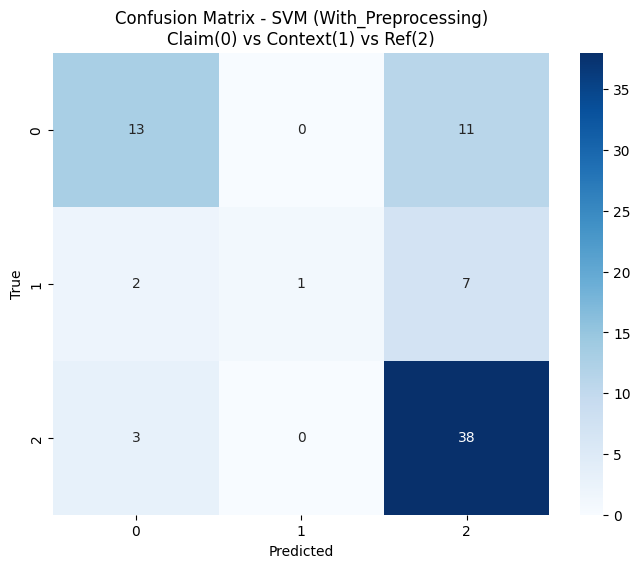


Classification Report:
              precision    recall  f1-score   support

       Claim       0.72      0.54      0.62        24
     Context       1.00      0.10      0.18        10
   Reference       0.68      0.93      0.78        41

    accuracy                           0.69        75
   macro avg       0.80      0.52      0.53        75
weighted avg       0.74      0.69      0.65        75

Accuracy: 0.6827 ± 0.0155
Precision: 0.7008 ± 0.0779
Recall: 0.6827 ± 0.0155
F1: 0.6280 ± 0.0249

🔍 Training model: KNN


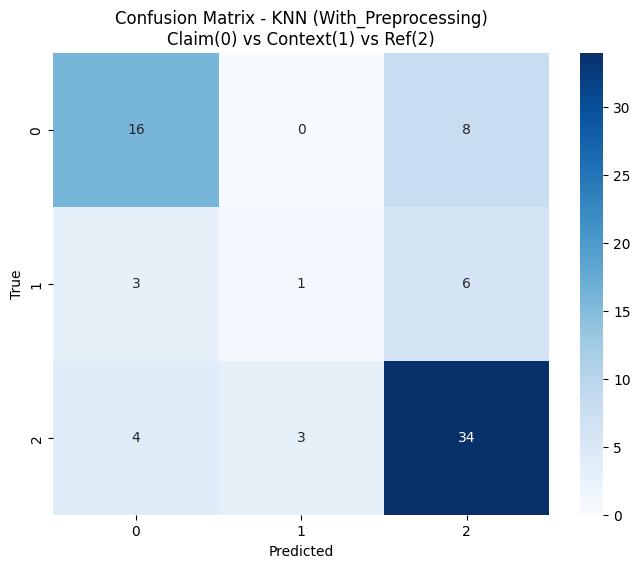


Classification Report:
              precision    recall  f1-score   support

       Claim       0.70      0.67      0.68        24
     Context       0.25      0.10      0.14        10
   Reference       0.71      0.83      0.76        41

    accuracy                           0.68        75
   macro avg       0.55      0.53      0.53        75
weighted avg       0.64      0.68      0.65        75

Accuracy: 0.6347 ± 0.0443
Precision: 0.6086 ± 0.0194
Recall: 0.6347 ± 0.0443
F1: 0.6137 ± 0.0318

🔍 Training model: AdaBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


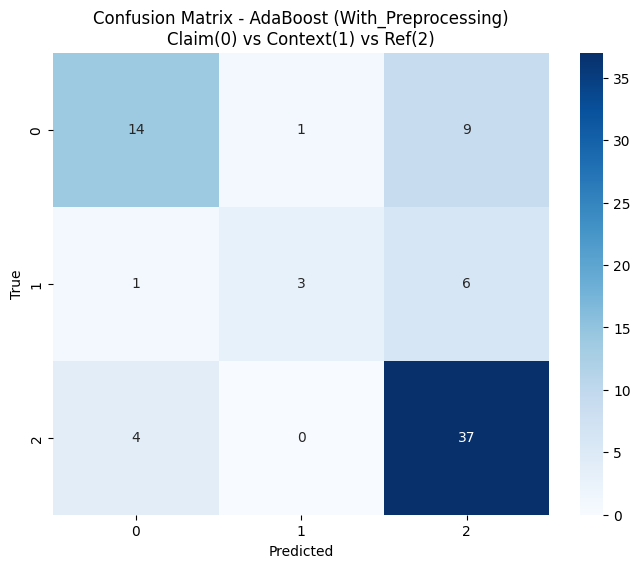


Classification Report:
              precision    recall  f1-score   support

       Claim       0.74      0.58      0.65        24
     Context       0.75      0.30      0.43        10
   Reference       0.71      0.90      0.80        41

    accuracy                           0.72        75
   macro avg       0.73      0.60      0.63        75
weighted avg       0.72      0.72      0.70        75

Accuracy: 0.6907 ± 0.0272
Precision: 0.6951 ± 0.0531
Recall: 0.6907 ± 0.0272
F1: 0.6484 ± 0.0368

🔍 Training model: XGBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:02:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:02:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:02:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:02:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_en

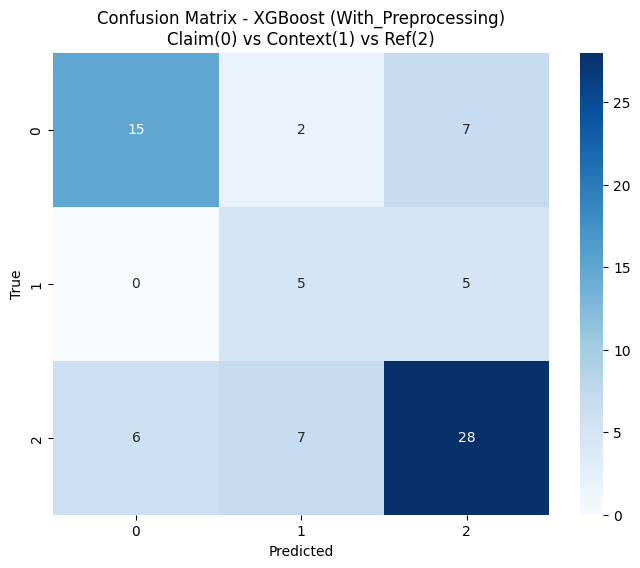


Classification Report:
              precision    recall  f1-score   support

       Claim       0.71      0.62      0.67        24
     Context       0.36      0.50      0.42        10
   Reference       0.70      0.68      0.69        41

    accuracy                           0.64        75
   macro avg       0.59      0.60      0.59        75
weighted avg       0.66      0.64      0.65        75

Accuracy: 0.6560 ± 0.0259
Precision: 0.6261 ± 0.0464
Recall: 0.6560 ± 0.0259
F1: 0.6322 ± 0.0299

🔍 Training model: Neural Network - MLP


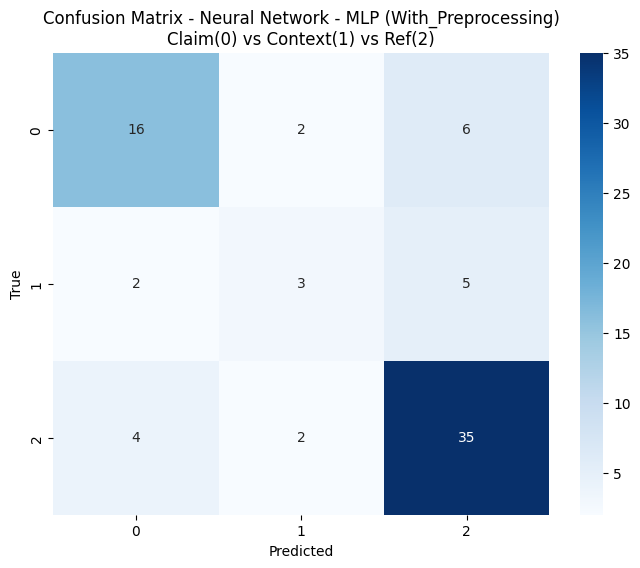


Classification Report:
              precision    recall  f1-score   support

       Claim       0.73      0.67      0.70        24
     Context       0.43      0.30      0.35        10
   Reference       0.76      0.85      0.80        41

    accuracy                           0.72        75
   macro avg       0.64      0.61      0.62        75
weighted avg       0.71      0.72      0.71        75

Accuracy: 0.6427 ± 0.0495
Precision: 0.6190 ± 0.0556
Recall: 0.6427 ± 0.0495
F1: 0.6117 ± 0.0610

Phase 2 Results:


,Model,Phase,Accuracy,Accuracy_Std,Precision,Precision_Std,Recall,Recall_Std,F1,F1_Std
0,Naïve Bayes,With_Preprocessing,0.573333,0.011926,0.620885,0.027033,0.573333,0.011926,0.449036,0.024884
1,Random Forest,With_Preprocessing,0.682667,0.017689,0.618476,0.014076,0.682667,0.017689,0.620576,0.019163
2,SVM,With_Preprocessing,0.682667,0.015549,0.700800,0.077903,0.682667,0.015549,0.627953,0.024929
3,KNN,With_Preprocessing,0.634667,0.044302,0.608566,0.019431,0.634667,0.044302,0.613702,0.031779
4,AdaBoost,With_Preprocessing,0.690667,0.027195,0.695061,0.053112,0.690667,0.027195,0.648360,0.036779
5,XGBoost,With_Preprocessing,0.656000,0.025854,0.626076,0.046392,0.656000,0.025854,0.632228,0.029934
6,Neural Network - MLP,With_Preprocessing,0.642667,0.049459,0.619022,0.055579,0.642667,0.049459,0.611654,0.060979


In [14]:
print("=== Phase 2: With Preprocessing ===")
df_phase2, text_column = pipeline.preprocess_data(df_clean.copy(), with_preprocessing=True)

# Load French stopwords
stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
french_stopwords = stopwords_df.index.tolist()

X_phase2, _ = pipeline.prepare_features(df_phase2, text_column, french_stopwords)
results_phase2 = pipeline.train_and_evaluate(X_phase2, df_clean['label'], "With_Preprocessing")

print("\nPhase 2 Results:")
display(results_phase2)

## Results Comparison

Compare the results between both phases

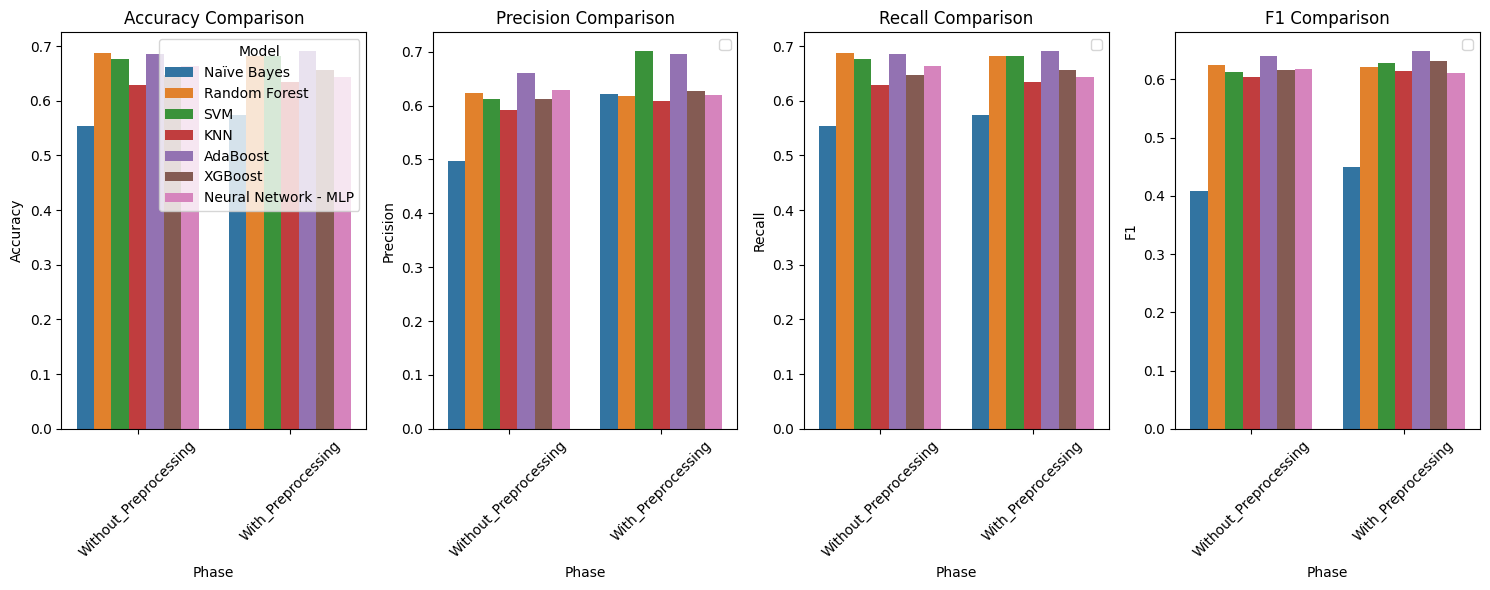

In [15]:
# Combine results
all_results = pd.concat([results_phase1, results_phase2])

# Plot comparison
plt.figure(figsize=(15, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=all_results, x='Phase', y=metric, hue='Model')
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    if i > 1:  # Only show legend for the first subplot
        plt.legend([])
    
plt.tight_layout()
plt.show()